# Predicción de casos de Coronavirus en Cuba

Esta página implementa una serie de modelos matemáticos para estudiar y predecir la cantidad de casos que se presentaran en las próximas semanas en Cuba. 

- Los datos fueron obtenidos de de la página web del Johns Hopkins University CSSE (https://github.com/CSSEGISandData/COVID-19)

- Además de estudiar los comportamientos de la pandemia en la Isla, se estudian otros países y regiones que están siendo afectadas. 

Los presentes modelos están basados en previos trabajos: 

 - Kalman Filter - https://github.com/Rank23/COVID19

In [345]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# confirmed cases 
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)

# deceased cases
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url, error_bad_lines=False)

# recovered cases / dataframe
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url, error_bad_lines=False)

# fix region names 
confirmed['Country/Region'] = confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "Unites States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "Unites States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "Unites States")
confirmed.columns[-1:]

Index(['3/29/20'], dtype='object')

In [346]:
# read population data for each province. China is divided into region whereas other regions of the world is nation 
population=pd.read_csv('../population.csv', sep=',', encoding='latin1') 
# population.head()

In [347]:
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])
# confirmed.head()

# merge region
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:5,:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,Population,region
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,"35,530,000",Afghanistan_nan
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,NaN,Albania_nan
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,201,230,264,302,367,409,454,511,"41,320,000",Algeria_nan
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,NaN,Andorra_nan
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,NaN,Angola_nan


In [348]:
# Confirmed Cuban casses time series dataframe
df_cuba = confirmed[confirmed['Country/Region'] == 'Cuba']
df_cuba_rec = recover[recover['Country/Region'] == 'Cuba']
# df_cuba

In [349]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [350]:
ts=create_ts(confirmed)
ts_d=create_ts(death)
ts_rec=create_ts(recover)
# ts.tail()

p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
# p.tail()

## Estudio de países más afectados en el planeta. 

En estas primeras gráficas descriptivas se enumeran los siguientes valores: 

- El número de casos confirmados en los 10 países más afectados. 
- El número de personas recuperadas en los 10 países más afectados. 
- El número de personas fallecidad en los 10 países más afectados. 

**Nota**: Todas las gráficas emplean escala logarítmica para mostrar cuando la pandamia comienza a disminuir el número de casos o muestra una tendencia a la mejora. 

Text(0.5, 1.0, 'Fallecidos países más afectados')

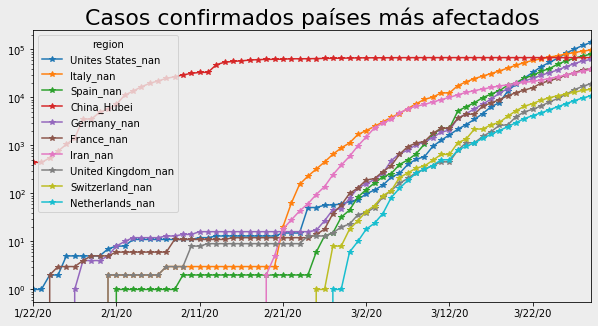

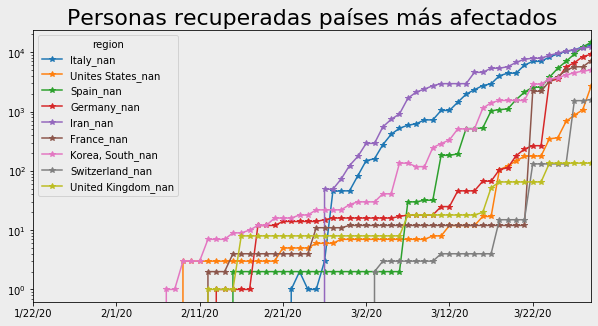

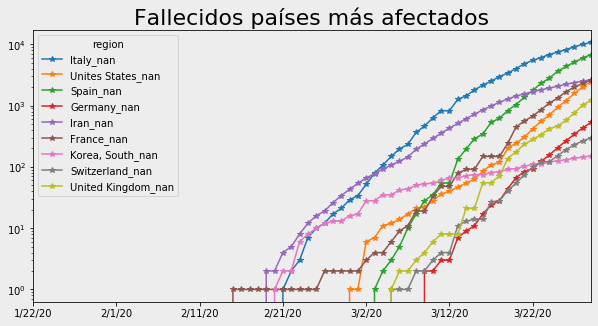

In [351]:
# comparing the 10 worst countries in the world
p.iloc[:,:10].plot(marker='*',figsize=(10,5), logy=True).set_title('Casos confirmados países más afectados',fontdict={'fontsize': 22})

# plot graph of hubei's recovered casses and other major areas
p_r=ts_rec.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,1:10].plot(marker='*',figsize=(10,5), logy=True).set_title('Personas recuperadas países más afectados',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,1:10].plot(marker='*',figsize=(10,5), logy=True).set_title('Fallecidos países más afectados',fontdict={'fontsize': 22})

## Casos confirmados en la región de Centro América. 

A continuación presentamos la cantidad de casos en los países de la región de Centro América y el Caribe, para los países: 

- Cuba
- Jamaica 
- Costa Rica
- Dominicana 
- Guatemala
- Mexico 
- Nicaragua
- Panama

Como se leen estos resultados: 

Cuando la curva, el gráfico es muy pendiente (parece una línea recta hacia arriba) entonces los valores (cantidad de casos, fallecidos, etc), está subiendo de manera exponencial y estamos en el peor momento de la pandemia (subida por la cuesta de la curva epidemiológica). 

Text(0.5, 1.0, 'Cantidad de fallecidos Centro América')

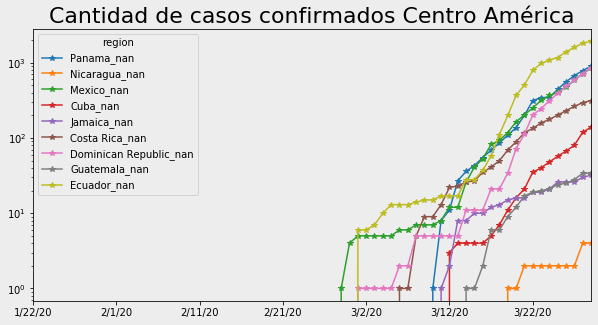

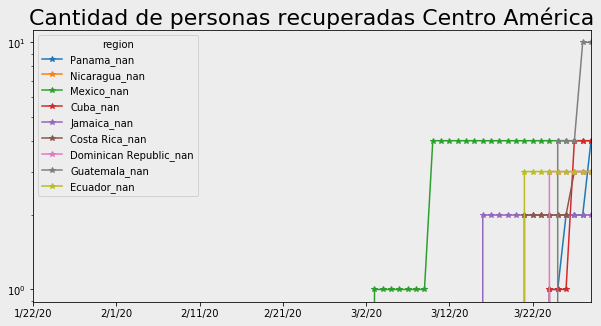

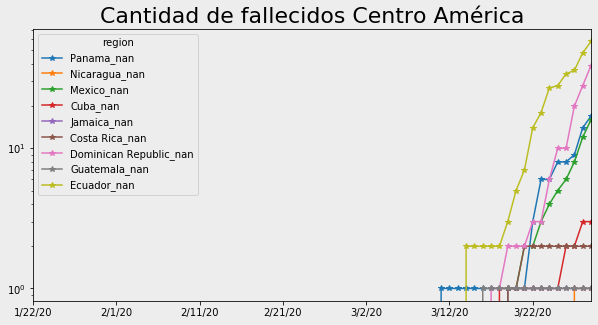

In [352]:
region = ['Panama_nan', 'Nicaragua_nan', 'Mexico_nan', 'Cuba_nan', 'Jamaica_nan', 'Costa Rica_nan', 'Dominican Republic_nan','Guatemala_nan', 'Ecuador_nan']
# comparing the 10 worst countries in the world
p.loc[:,region].plot(marker='*',figsize=(10,5), logy=True).set_title('Cantidad de casos confirmados Centro América',fontdict={'fontsize': 22})

# plot graph of hubei's recovered casses and other major areas
p_r=ts_rec.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_r.loc[:,region].plot(marker='*',figsize=(10,5), logy=True).set_title('Cantidad de personas recuperadas Centro América',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_d.loc[:,region].plot(marker='*',figsize=(10,5), logy=True).set_title('Cantidad de fallecidos Centro América',fontdict={'fontsize': 22})

### Conclusiones 20/March/2020

- Cuba se encuentra en la tendencia/patrón más pronunciado de la región en la detención de casos.
- La cantidad de fallecidos en la isla es mucho menor que en otros países de la región. 

## Análisis del la curva de crecimiento para para cada uno de los países de la región. 

In [353]:
%load_ext autoreload
%autoreload 2
import sys
from covid19_util import *
from covid19_processing import *
data = Covid19Processing()
data.process(rows=20, debug=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Raw confirmed cases data, per region/state

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,...,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,...,40,74,84,94,110,110,120
1,NaN,Albania,41.1533,20.1683,0,0,0,...,104,123,146,174,186,197,212
2,NaN,Algeria,28.0339,1.6596,0,0,0,...,230,264,302,367,409,454,511
3,NaN,Andorra,42.5063,1.5218,0,0,0,...,133,164,188,224,267,308,334
4,NaN,Angola,-11.2027,17.8739,0,0,0,...,3,3,3,4,4,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,Burma,21.9162,95.9560,0,0,0,...,0,0,0,0,8,8,10
249,Anguilla,United Kingdom,18.2206,-63.0686,0,0,0,...,0,0,0,0,0,2,2
250,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,...,0,0,0,0,0,2,2
251,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,...,0,0,0,0,0,4,4


### Table of confirmed cases by country

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29
Country/Region,,,,,,,,,,,
Afghanistan,0,0,0,0,0,...,84,94,110,110,120
Albania,0,0,0,0,0,...,146,174,186,197,212
Algeria,0,0,0,0,0,...,302,367,409,454,511
Andorra,0,0,0,0,0,...,188,224,267,308,334
Angola,0,0,0,0,0,...,3,4,4,5,7
Antigua and Barbuda,0,0,0,0,0,...,3,7,7,7,7
Argentina,0,0,0,0,0,...,387,502,589,690,745
Armenia,0,0,0,0,0,...,265,290,329,407,424
Australia,0,0,0,0,0,...,2364,2810,3143,3640,3984


### Table of confirmed cases by continent/region

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29
Asia,45,62,218,554,653,...,135225,140676,147703,155031,162329
Europe,0,0,0,0,0,...,249006,284057,319718,356365,385858
Africa,0,0,0,0,0,...,2773,3326,3885,4225,4786
North America,0,0,0,1,1,...,70734,89948,108800,130023,150609
South America,0,0,0,0,0,...,6568,7688,8856,10144,11197
Oceania,0,0,0,0,0,...,2575,3099,3517,4097,4504
All except China,0,0,0,7,11,...,385992,447809,511394,578707,637995
World,45,62,218,555,654,...,467653,529591,593291,660706,720117


## Análisis de la velocidad de creciemiento en diferentes países

La velocidad de creciemiento del número de casos por día permite estudiar si la epidemia esta creciendo, si está mejorando la situación o se mantiene estable. Por ejemplo, si el número de casos es 100 y al siguiente día al siguiente día se reportan 150 nuevos casos, la velocidad de creciemiento es 1.5

Algunas reglas para este gráfico: 

- Una velocidad de creciemiento mayor que 1 significa que la epidamia esta creciendo aceleradamente, esta creciendo exponencialmente. 
- Una velocidad de crecimiendo 1 significa que está creciendo linealmente. 
- Una velcocidad de crecimiento menor que 1, significa que la epidemia está creciendo pero aun un ritmo menor, se está deshacelerando. 
- Un valor 0 de velocidad de crecimiento significa que no hay nuevos casos reportados. 

En el siguiente gráfico medimos la velocidad de creciemiento cada dos días. 

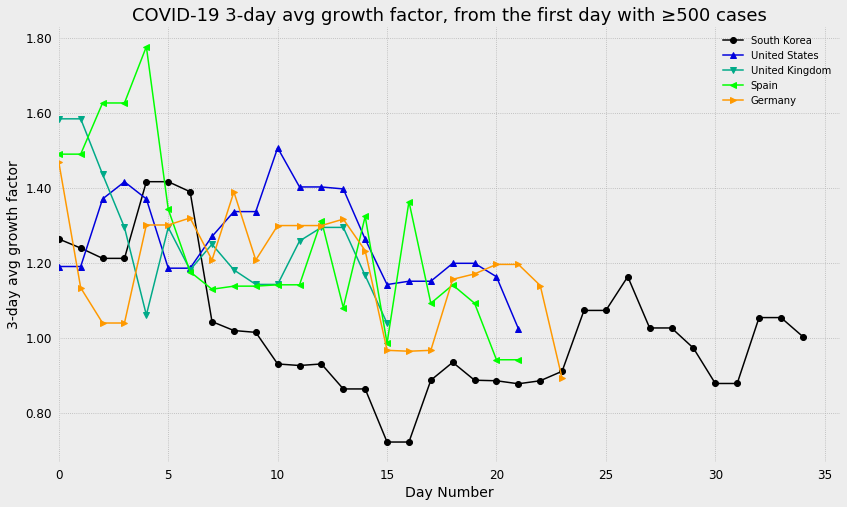

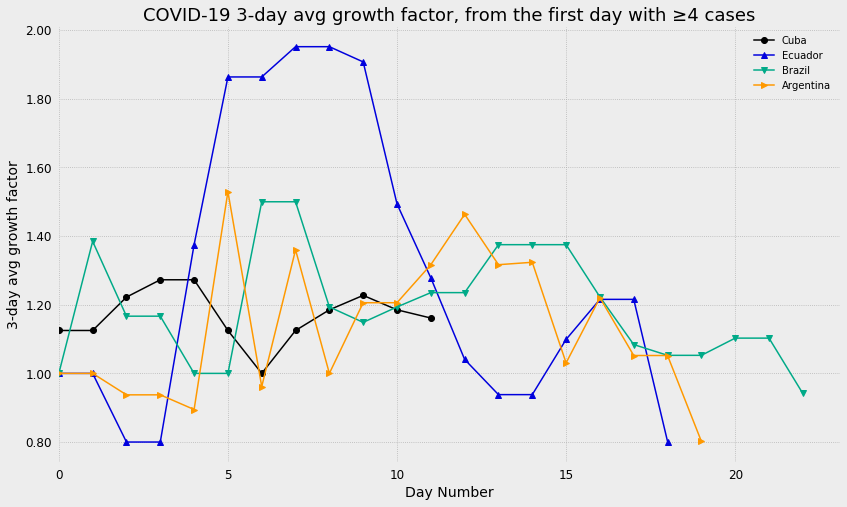

In [354]:
import matplotlib.pyplot as plt
s=3
countries_to_plot2 = ["South Korea", "United States", "United Kingdom","Spain", "Germany"]
data.plot("day_number", "growth_factor", countries_to_plot2, min_cases=500, sigma=s, 
          fixed_country_colors=False, use_log_scale=False)

countries_to_plot3 = ["Cuba", "Ecuador", "Brazil", "Nicaragua", "Argentina"]
data.plot("day_number", "growth_factor", countries_to_plot3, min_cases=4, sigma=s, 
          fixed_country_colors=False, use_log_scale=False) 

## Predicción de la cantidad de casos siguiendo el modelo (Kalman Filter)

El [filtro de Kalman](https://es.wikipedia.org/wiki/Filtro_de_Kalman) es un algoritmo desarrollado por Rudolf E. Kalman en 1960 que sirve para poder identificar el estado oculto (no medible) de un sistema dinámico lineal, sirve además cuando el sistema está sometido a ruido blanco aditivo. Ya que el filtro de Kalman es un algoritmo recursivo, puede correr en tiempo real usando únicamente las mediciones de entrada actuales, el estado calculado previamente y su matriz de incertidumbre, y no requiere ninguna otra información adicional. El filtro de Kalman tiene numerosas aplicaciones en tecnología. Una aplicación común es la guía, navegación y control de vehículos, especialmente naves espaciales. Además, se utiliza ampliamente en campos como el procesamiento de señales y la econometría.

El presente modelo permite entender los datos en un evento dinámico (que cambia constantemente) y predecir cual es el valor que sigue (en este caso los posibles nuevos casos) a corto plazo. En el caso de un evento epidemiológico donde existen tantas variables como: nivel de contacto de la población, medidas de distanciamiento y mitigación tomados por el estado, el [número básico de reproducción del virus SARS-CoV-2](https://cubaciencia.blogspot.com/2020/03/tres-conceptos-que-tengo-que-entender.html).

In [355]:
# Create data for R script
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')
# ENTER YOUR GOOGLE DRIVE PATH TO THE COLABORATORY
project_path_py = './ts_r.csv' 
ts_r.to_csv(project_path_py)
# ts_r.tail()

In [356]:
# Starting from here, we code in R. 
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [357]:
%%R
# ENTER YOUR GOOGLE DRIVE PATH TO THE COLABORATORY
project_path_R = './ts_r.csv'
require(pracma)
require(Metrics)
require(readr)
all<- read_csv(project_path_R)
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

In [358]:
p=%R pred_all

In [359]:
# preceding days' weather data
w=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')
#w['date']=pd.to_datetime(w['date'],errors ='coerce')

# weather forecast data
w_forecast=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

In [360]:
############ Merge R output due to package problem
t=ts_d
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']
# t.tail(20)

Entrenamiento del Modelo

In [361]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)
t.tail(7)

,date,region,confirmed
17450,2020-03-24,Zimbabwe_nan,3
17451,2020-03-25,Zimbabwe_nan,3
17452,2020-03-26,Zimbabwe_nan,3
17453,2020-03-27,Zimbabwe_nan,5
17454,2020-03-28,Zimbabwe_nan,7
17455,2020-03-29,Zimbabwe_nan,7
17456,2020-03-30,Zimbabwe_nan,0


In [362]:
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is t.iloc[i-2,1]):
    t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
    t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
    t.iloc[i,9]=t.iloc[i-1,2]
  if(t.iloc[i,1] is t.iloc[i-4,1]):
    t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
    t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
  if(t.iloc[i,1] is t.iloc[i-8,1]):
    t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
    t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(1)
train['population']=train['population'].astype('int32')
train['infected_rate'] =train['last_day']/train['population']*10000
train=train.merge(w,how='left',on=['date','region'])
train=train.sort_values(['region', 'date'])

Modelo Kalman 

In [363]:
# Select region
region='Cuba_nan'
evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0

In [364]:
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    # print(ex)
    pred=np.array(t.iloc[i-len(ts):i,2])
    # print(pred)
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
    # print(evaluation)

p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p.tail(10)

In [365]:
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
# p.tail(10)

## Modelo Kalman Resultados para Cuba. 

El número de casos para Cuba está creciendo de forma exponencial, y para el día 28 ha tenido un número mayor de infecciones (39) que lo esperado según la predicción (10). 

En la medida que pasen los días se podrá ajustar mejor la Curva. 


      region         mse      rmse       mae
94  Cuba_nan  340.102941  18.44188  3.955882


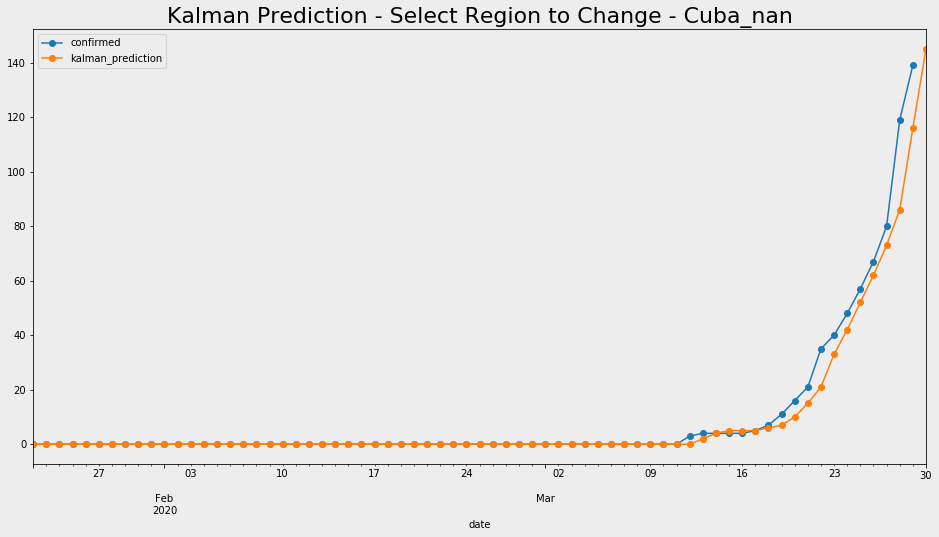

In [366]:
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]),fontdict={'fontsize': 22})
print(evaluation[evaluation['region']==p.iloc[0,0]])

## Predicción del Modelo Kalman para los Estados Unidos. 

                region           mse         rmse     mae
245  Unites States_nan  3.549997e+08  18841.43566  3918.5


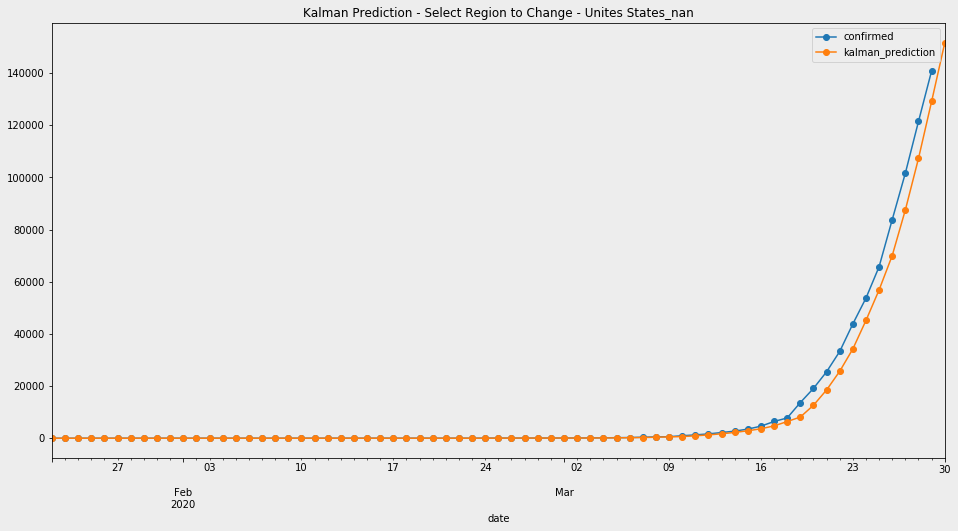

In [367]:
# Select region
region='Unites States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])

In [368]:
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='8G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,17 hours 42 mins
H2O cluster timezone:,Europe/London
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,12 days
H2O cluster name:,H2O_from_python_yperez_1d69r8
H2O cluster total nodes:,1
H2O cluster free memory:,7.226 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [369]:
# today's date
from datetime import date, datetime, timedelta
today_int = date.today()
today_str = str(today_int)
today_str
# recent days for boosting below
d = datetime.today() - timedelta(days=5)
boosting_date = str(d.date())
boosting_date
# available datasets to train
d2 = datetime.today() - timedelta(days=1)
training_d = str(d2.date())
training_d

'2020-03-29'

In [370]:
#train.tail()

In [371]:
train=train.fillna(0) 
train_df=train[train['date']<training_d]

# some bootstrap to give more weight for recent days
boots=train_df[train_df['date']>=boosting_date] 
train_df=train_df.append([boots[boots['date']>=boosting_date]]*1000,ignore_index=True)
train_df_hubei=train_df[train_df['region']=='China_Hubei']
test=train[train['date']>=training_d]
test=test[test['date']<training_d]
#test

In [372]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            # '1_day_change_rate', 
            #'3_day_change_rate',
             '7_day_change_rate', 
            'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
          ]
x=train_df[x_col]
#x.tail()
y=train_df['confirmed']
#y.tail()
reg = LinearRegression().fit(x,y)
# pred2=reg.predict(test[x_col])
pred2=reg.predict(x)
pred2=pd.DataFrame(pred2)
pred2=round(pred2)
# pred2
len(pred2[0])
len(test['confirmed'].values)

0

In [373]:
train_h20 = h2o.H2OFrame(train_df)
train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
training_columns = ['region','1_day_change', '3_day_change', '7_day_change', '1_day_change_rate', '3_day_change_rate',
                    '7_day_change_rate', 'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
                   ]                 
# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)
model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Modelo Kalman predicción para los próximos días.  

In [374]:
%%R
require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("./ts_r.csv")
all$X1<-NULL
for (i in 1:30) { # Set i days prediction
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

Text(0.5, 1.0, 'Kalman Prediction Cuba_nan')

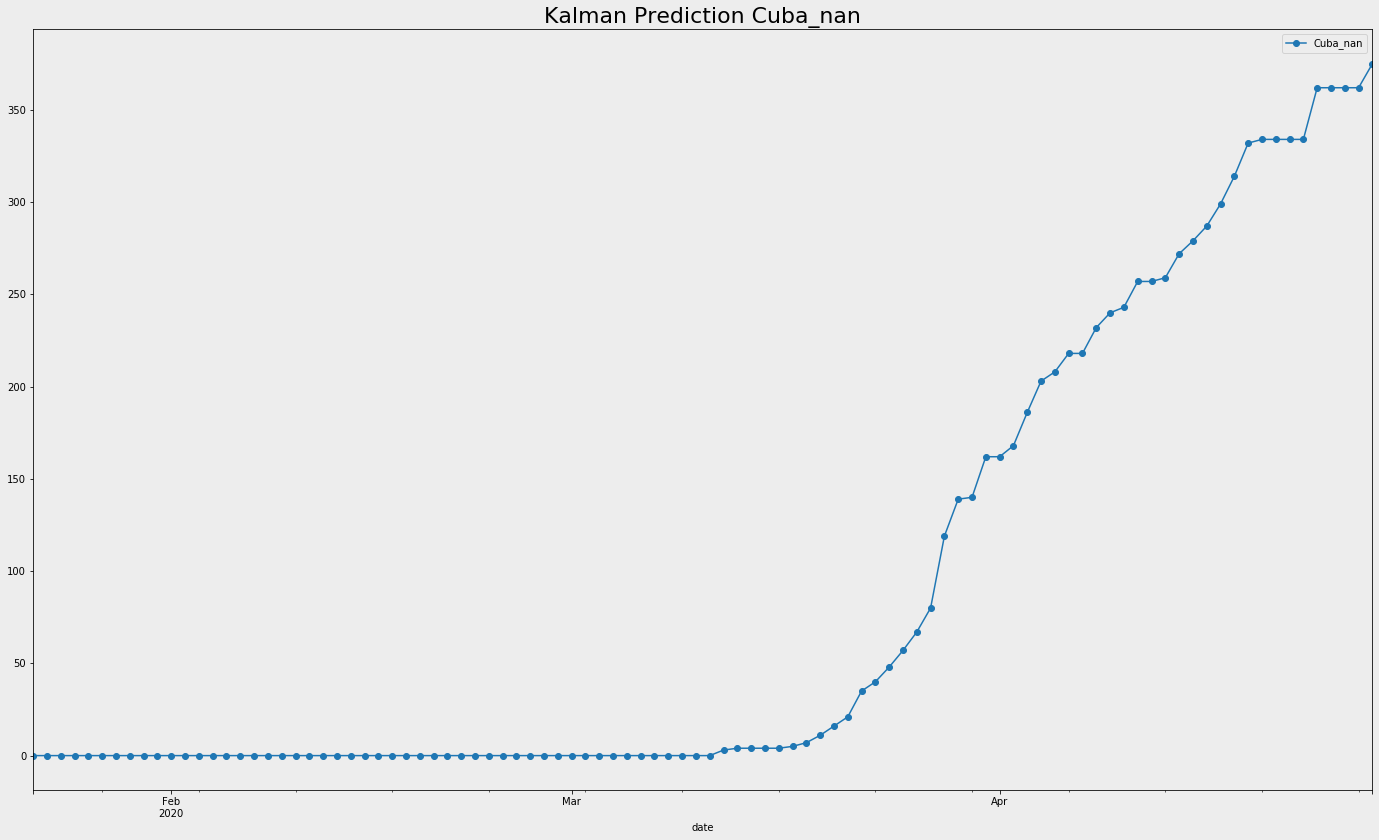

In [375]:
all_new=%R all_new
all_new['date']=pd.to_datetime(all_new['date'],unit='d')
region = ['date', "Cuba_nan"]
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction {}'.format(region[1]), fontdict={'fontsize': 22})

In [376]:
prediction_one_month = p_kalman.tail(30)
prediction_two_weeks = prediction_one_month.head(15)
prediction_two_weeks

,Cuba_nan
date,
2020-03-30,140.0
2020-03-31,162.0
2020-04-01,162.0
2020-04-02,168.0
2020-04-03,186.0
2020-04-04,203.0
2020-04-05,208.0
2020-04-06,218.0
2020-04-07,218.0


In [377]:
t.to_csv(r't.csv')

### Curva logistica extrapolación de casos 

El siguiente análisis intenta ajustar la cantidad de casos a una curva [logística o de 'forma de S'](https://es.wikipedia.org/wiki/Funci%C3%B3n_log%C3%ADstica) a los datos hasta el momento. Si bien es razonable esperar que el número total de casos en cualquier epidemia eventualmente tenga esa forma, los parámetros cruciales son difíciles de predecir. Por ejemplo, los cambios en la tasa de propagación debido a cambios en las políticas de mitigación, o la posibilidad de una segunda ola de infecciones.

Para algunos países, los resultados parecen bastante plausibles, mientras que para otros puede dar resultados extremadamente improbables, como predecir una cantidad de casos que muchas veces es la población del país.

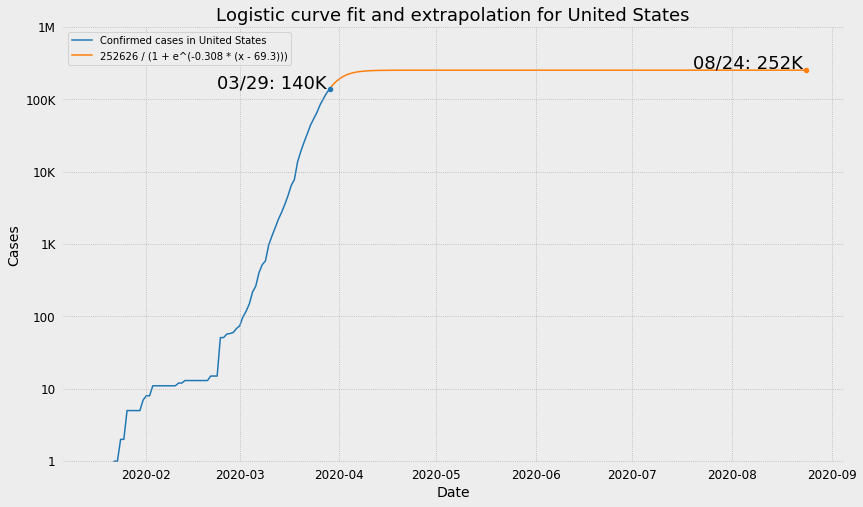

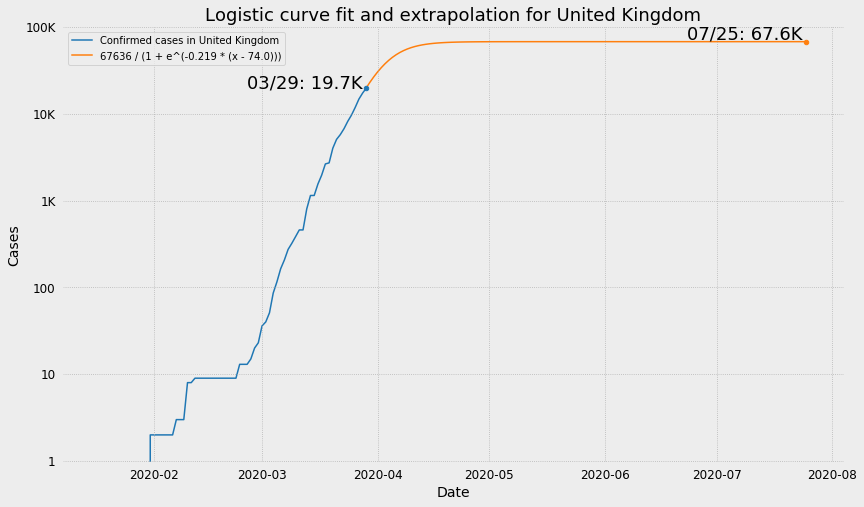

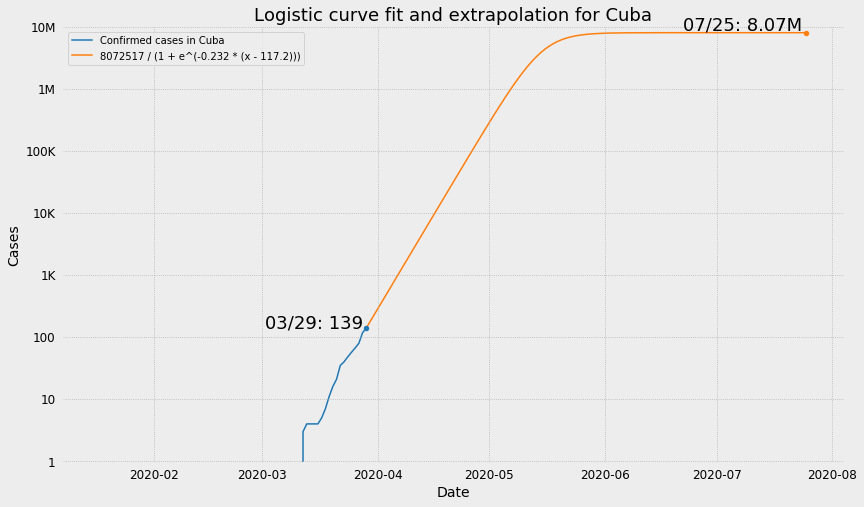

In [378]:
data.curve_fit("United States", days=150)
data.curve_fit("United Kingdom", days=120)
data.curve_fit("Cuba", days=120)

### Simulación del futuro desarrollo de la epidemia teniendo en cuenta diferentes modelos probabilísticos. 

Los siguientes modelos presentan 3 simulaciones siendo la única diferencia la efectividad de las medidas de distanciamiento, y el confinamiento absoluto. 

- Confinamiento efectivo: Asume condiciones normales al comienzo, seguido de un bloqueo rápido y muy estricto durante el tiempo que sea necesario. Este es el mejor caso, pero poco probable.

- Confinamiento ineficaz: Se realiza un intento tardío y poco entusiasta de confinamiento, pero el virus sigue propagándose a media velocidad. Esto sería bastante malo; la mayoría de la población se infectaría antes de que una vacuna esté disponible.

- Medidas y batalla prolongada: los períodos alternos de bloqueos estrictos con períodos más relajados suavizan el golpe a la economía y detienen la cantidad de infecciones hasta que se pueda desarrollar una vacuna, o hasta que finalmente se active la inmunidad colectiva.

Tenga en cuenta que esto es muy especulativo y altamente dependiente de:

- El valor elegido para el factor de mitigación. Junto con R0, esto representa los efectos de cuarentenas, confinamiento y otras contramedidas, y determina la tasa reproductiva efectiva.
   - Si R0 es 2, el factor de mitigación es 0.8, y el 98% de la población aún no ha sido infectado, Reff = 2 * 0.8 * 0.98 = 1.568, lo que significa que efectivamente, cada 1000 personas infectadas propagarán la enfermedad a un promedio de 1568 personas no infectadas.

La entrada para el factor de mitigación es una lista que se interpola a la misma longitud que la cantidad de días para simular. Por ejemplo, simulando 5 días con una tendencia de mitigación de [1.0, 0.8] utilizará tasas de crecimiento de [1.0, 0.95, 0.90, 0.85, 0.80].
El valor elegido para la tasa de letalidad (cfr); la evidencia hasta ahora sugiere un rango de 0.01 a 0.06

Otras limitaciones de la simulación:

- No considera el tiempo de incubación
- No tiene en cuenta los viajes internacionales y la posible recontaminación / resiembra para las segundas y posteriores olas.
- No considera el efecto sobre la tasa de mortalidad cuando el número de casos activos supera la capacidad.

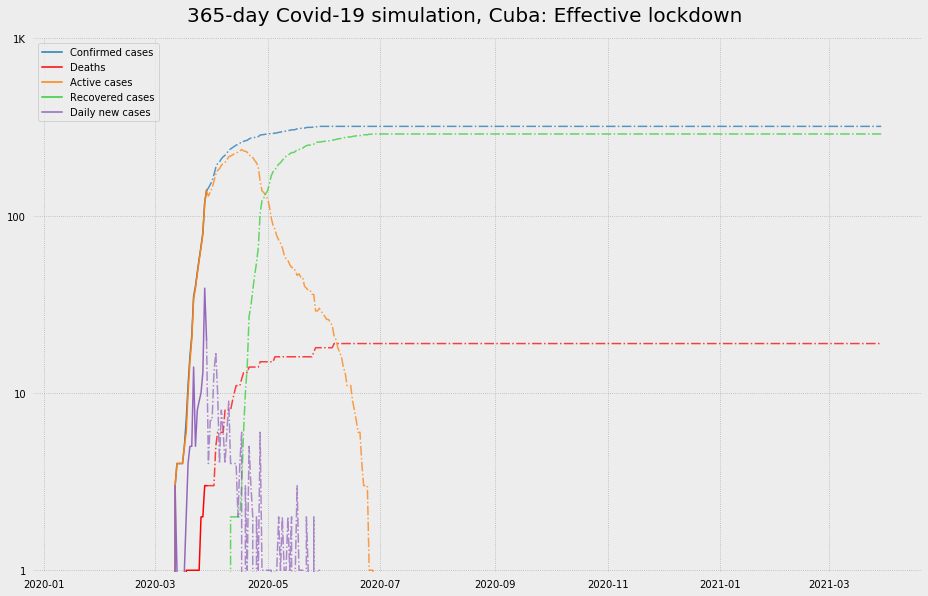

### Effective lockdown final tally:

Confirmed: 319,
Deaths: 19,
Recovered: 289,
Peak active: 236 at 2020-04-17,
Uninfected: 11.4M


In [379]:
S = 0.20              # mitigation effectiveness under severe lockdown
M = 0.30              # mitigation effectiveness under moderate lockdown
W = 0.50              # mitigation effectiveness under weak lockdown
N = 1.00              # mitigation effectiveness under normal conditions

# Values inspired by the mitigation effectiveness analysis below
I = 0.31   # Italy, Iran
C = 0.22   # China
K = 0.175  # South Korea

cfr = 0.06 # https://arxiv.org/abs/2003.09320
r0 = 3.1   # https://arxiv.org/abs/2003.09320

scenarios = {
    "Effective lockdown":   [S,S,S,S,M,M,M,M,M,M,M,M],
    "Ineffective lockdown": [N,W,W,W],
    "Prolonged battle":     [M,M,W,S,M,M,W,S,M,M,W,S]
}

scenario = "Effective lockdown"
simulation = data.plot_simulation(country="Cuba", days = 365, 
                                  mitigation_trend=scenarios[scenario], 
                                  cfr=cfr, r0=r0, scenario_name=scenario)

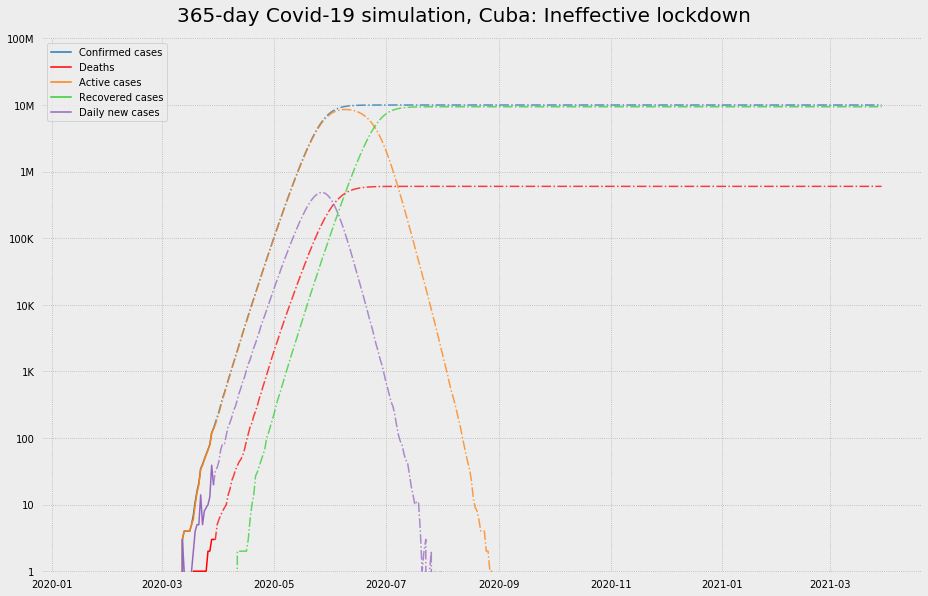

### Ineffective lockdown final tally:

Confirmed: 10.0M,
Deaths: 600K,
Recovered: 9.4M,
Peak active: 8.56M at 2020-06-09,
Uninfected: 1.41M


In [387]:
scenario = "Ineffective lockdown"
simulation = data.plot_simulation(country="Cuba", days = 365,
                                  mitigation_trend=scenarios[scenario], 
                                  cfr=0.06, r0=3.1, scenario_name=scenario)

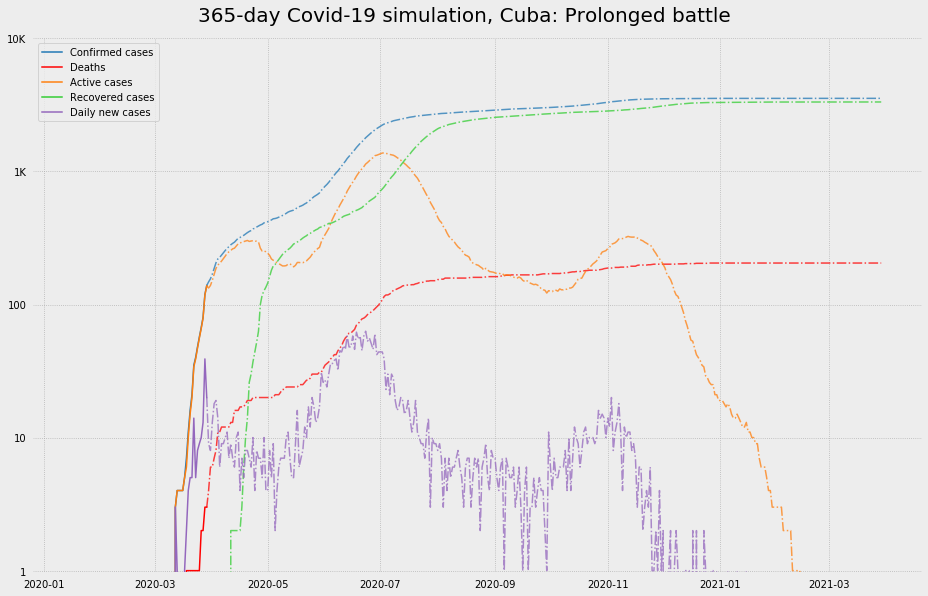

### Prolonged battle final tally:

Confirmed: 3.54K,
Deaths: 205,
Recovered: 3.32K,
Peak active: 1.37K at 2020-07-03,
Uninfected: 11.4M


In [388]:
scenario = "Prolonged battle"
simulation = data.plot_simulation(country="Cuba", days = 365, 
                                  mitigation_trend=scenarios[scenario], 
                                  cfr=0.06, r0=3.1, scenario_name=scenario)

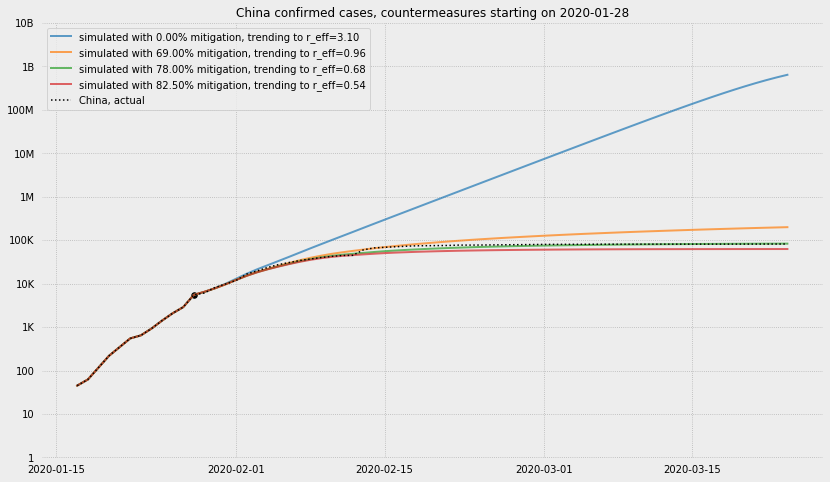

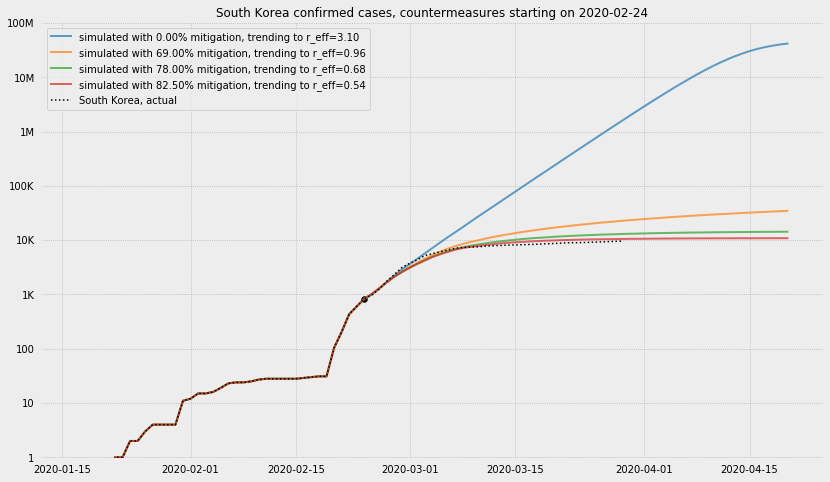

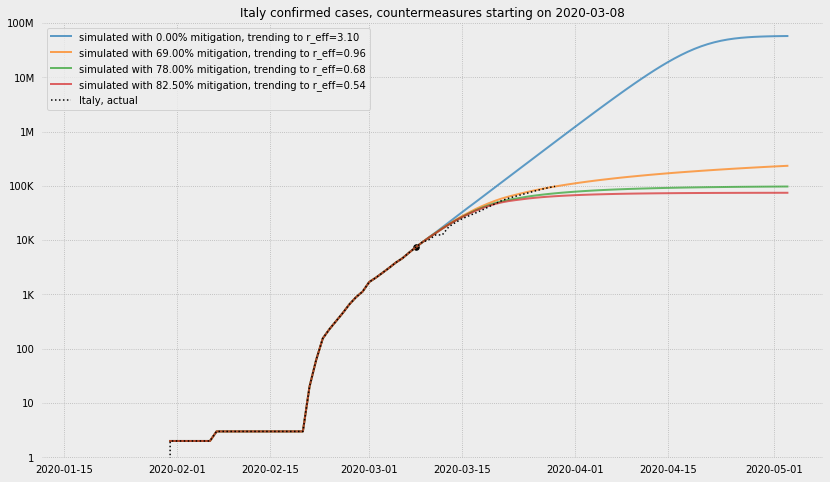

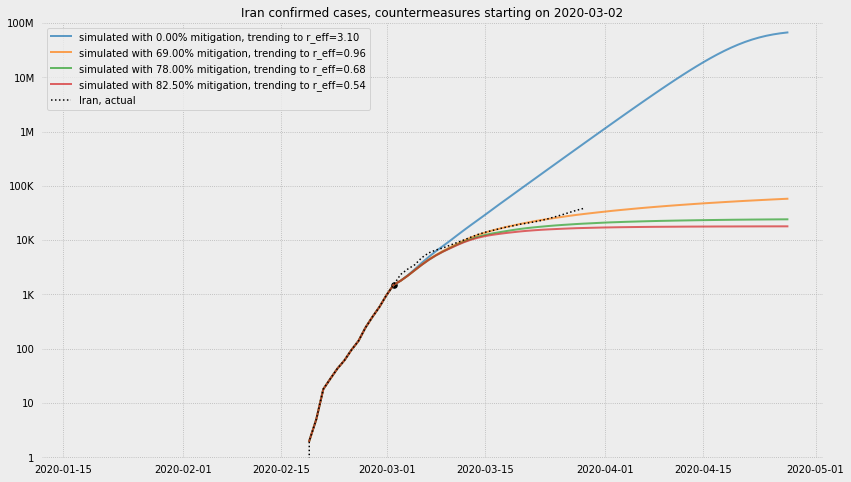

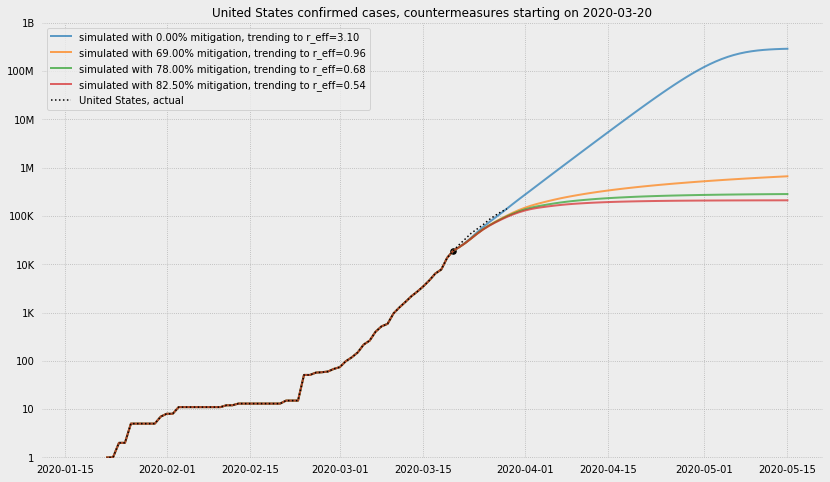

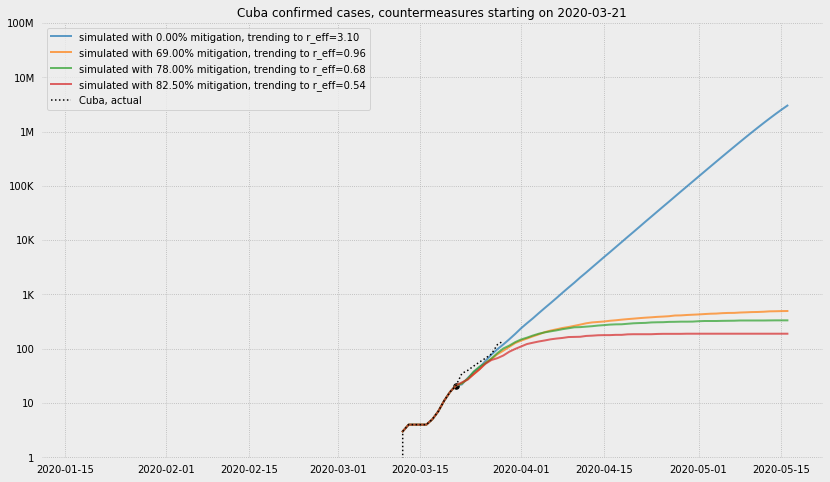

In [386]:
cfr = 0.04
r0 = 3.1

country_start_days = {
    "China": 9,
    "South Korea": 33,
    "Italy": 37,
    "Iran": 12,
    "United States": 58, 
    "Cuba": 9
}

for country in country_start_days:
    s = country_start_days[country]
    for i, f in enumerate([1.0, 0.31, 0.22, 0.175]):
        r_eff = r0 * f        
        sim, today = data.simulate_country(country, days=56, cfr=cfr, r0=r0, from_day=s, mitigation_trend=[1]+4*[f])
        actual, _ = data.simulate_country(country, days=0, cfr=cfr, r0=r0, from_day=-1, mitigation_trend=[1])
        
        plt.plot(sim.confirmed, label=f"simulated with {1-f:.2%} mitigation, trending to "+
                 f"r_eff={r_eff:.2f}", linestyle="-", lw=2, alpha=0.7)
        
    plt.plot(actual.confirmed[actual.confirmed.index <= sim.index[-1]], ":", label=f"{country}, actual", c="k")
    plt.scatter(today, sim.confirmed[today], c="k", s=30)
    plt.grid()
    plt.legend()
    set_y_axis_format(actual.max().max(), True)
    plt.title(f"{country} confirmed cases, countermeasures starting on {today.date()}")
    plt.show()